In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# 配置参数
selected_sensors = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8',  'sm_11', 'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
alpha = 0.3  # 指数平滑系数

In [3]:
def load_data(file_path):
    """加载并预处理原始数据"""
    df = pd.read_csv(file_path, sep=' ', header=None)
    df = df.dropna(axis=1, how='all')  # 删除空列
    
    # 定义列名（与NASA CMAPSS数据格式一致）
    columns = ['unit', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
        [f'sm_{i}' for i in range(1,22)]
    df.columns = columns[:df.shape[1]]
    
    return df

In [4]:
def preprocess_data(df, scaler=None, fit_scaler=False):
    """数据预处理（标准化）"""
    sensor_data = df[selected_sensors].values
    
    if fit_scaler:
        scaler = StandardScaler().fit(sensor_data)
    
    if scaler is not None:
        sensor_data = scaler.transform(sensor_data)
    
    return sensor_data, scaler

In [5]:

def generate_hi(sensor_data, pca_model):
    """生成健康指标"""
    # PCA转换
    pca_features = pca_model.transform(sensor_data).flatten()
    
    # 方向校准（确保HI随时间下降）
    if np.corrcoef(pca_features, np.arange(len(pca_features)))[0, 1] > 0:
        pca_features = -pca_features
    
    # 归一化到[0,1]范围（基于当前发动机）
    hi = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
    
    # 指数平滑
    hi_smoothed = exponential_smoothing(hi, alpha)
    
    return hi_smoothed

In [6]:
def exponential_smoothing(series, alpha):
    """指数平滑"""
    smoothed = np.zeros_like(series)
    smoothed[0] = series[0]
    for t in range(1, len(series)):
        smoothed[t] = alpha * series[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

In [7]:
train_df = load_data("data/train_FD001.txt")

In [ ]:
print(train_df.head())

In [9]:
# 训练标准化器
train_sensor_data, scaler = preprocess_data(train_df, fit_scaler=True)

In [10]:
# 训练PCA模型（使用所有训练数据）
pca = PCA(n_components=1)
pca.fit(train_sensor_data)

PCA(n_components=1)

In [17]:
# 生成训练集HI
train_hi = []
for unit in train_df['unit'].unique():
    engine_data = train_df[train_df['unit'] == unit]
    sensor_data, _ = preprocess_data(engine_data, scaler)
    hi = generate_hi(sensor_data, pca)
    
    train_hi.append(pd.DataFrame({
        'unit': unit,
        'time': engine_data['time'],
        'HI_smooth': hi,
        'anomaly_point':0
    }))

train_hi_df = pd.concat(train_hi)
train_hi_df.to_csv('HI_train_FD001.csv', index=False)
print("训练集HI保存至 HI_train_FD001.csv")

训练集HI保存至 HI_train_FD001.csv


In [12]:
test_df = load_data("data/test_FD001.txt")

In [13]:
# 预处理测试数据（使用训练集的标准化参数）
test_sensor_data, _ = preprocess_data(test_df, scaler=scaler)

In [18]:
# 生成测试集HI
test_hi = []
for unit in test_df['unit'].unique():
    engine_data = test_df[test_df['unit'] == unit]
    sensor_data, _ = preprocess_data(engine_data, scaler)
    hi = generate_hi(sensor_data, pca)
    
    test_hi.append(pd.DataFrame({
        'unit': unit,
        'time': engine_data['time'],
        'HI_smooth': hi,
        'anomaly_point':0
    }))

test_hi_df = pd.concat(test_hi)
test_hi_df.to_csv('HI_test_FD001.csv', index=False)
print("测试集HI保存至 HI_test_FD001.csv")

测试集HI保存至 HI_test_FD001.csv


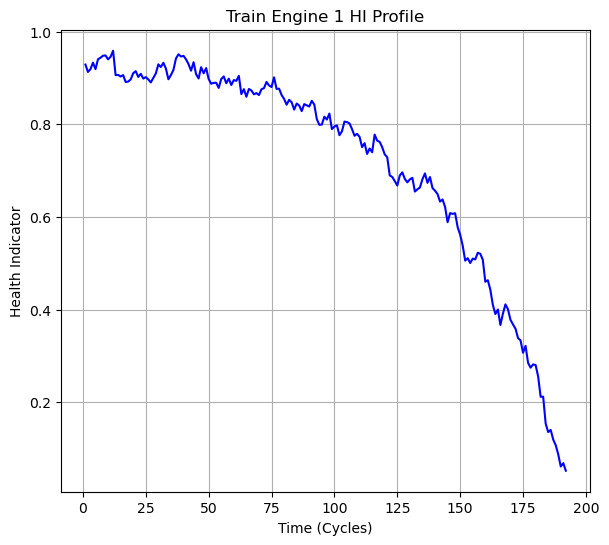

In [20]:
plt.figure(figsize=(15, 6))
# 训练集示例
plt.subplot(121)
sample_train = train_hi_df[train_hi_df['unit'] == 1]
plt.plot(sample_train['time'], sample_train['HI_smooth'], color='blue')
plt.title('Train Engine 1 HI Profile')
plt.xlabel('Time (Cycles)')
plt.ylabel('Health Indicator')
plt.grid(True)

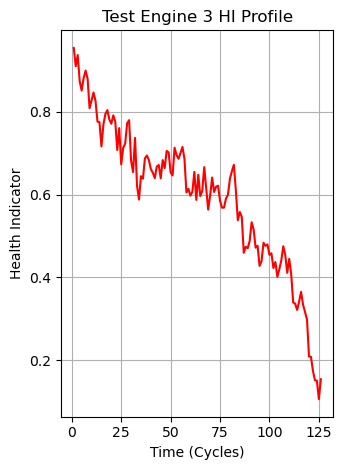

In [21]:
# 测试集示例
plt.subplot(122)
sample_test = test_hi_df[test_hi_df['unit'] == 3]
plt.plot(sample_test['time'], sample_test['HI_smooth'], color='red')
plt.title('Test Engine 3 HI Profile')
plt.xlabel('Time (Cycles)')
plt.ylabel('Health Indicator')
plt.grid(True)

plt.tight_layout()
plt.show()